In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# 機器學習相關套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

# 繪圖風格設定
sns.set(style="whitegrid")
# 設定字體以支援中文顯示 (視你的作業系統調整，Windows 用 Microsoft JhengHei)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

print("✅ 環境設置完成！")

✅ 環境設置完成！


In [2]:
# Cell 2: Data Loading & Cleaning
print("步驟 1/4: 資料讀取與清洗...")

# 1. 讀取資料 (使用 low_memory=False 避免型別警告)
df = pd.read_csv('dataset/games.csv', low_memory=False)
print(f"   📊 原始資料筆數: {len(df)}")

# 2. 定義我們要用來訓練的數值欄位
# 包含基礎數據與進階數據 (若你的 csv 有進階數據，這裡可以加進去，如 'OFF_RATING')
numeric_cols = [
    'PTS', 'REB', 'AST', 'FG_PCT', 'FG3_PCT', 'USG_PCT', 'MIN', 
    'OFF_RATING', 'DEF_RATING', 'PACE', 'TS_PCT' # 如果你的 CSV 有這些進階數據就留著，沒有的話請刪除這行
]

# 過濾掉 CSV 中不存在的欄位 (防呆)
valid_cols = [c for c in numeric_cols if c in df.columns]

# 3. 強力清洗：強制轉為數值，錯誤的變 NaN
print("   🧹 正在清除髒資料 (非數值內容)...")
for col in valid_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. 移除含有 NaN 的行 (丟棄髒資料)
df_clean = df.dropna(subset=valid_cols).copy()
print(f"   ⚠️ 移除了 {len(df) - len(df_clean)} 筆格式錯誤的資料")

# 5. 時間排序
try:
    df_clean['GAME_DATE'] = pd.to_datetime(df_clean['GAME_DATE'])
except: pass
df_clean = df_clean.sort_values(by=['Player_ID', 'GAME_DATE']).reset_index(drop=True)

print(f"   ✅ 清洗後剩餘資料: {len(df_clean)}")

步驟 1/4: 資料讀取與清洗...
   📊 原始資料筆數: 54044
   🧹 正在清除髒資料 (非數值內容)...
   ⚠️ 移除了 174 筆格式錯誤的資料
   ✅ 清洗後剩餘資料: 53870


In [3]:
# Cell 3: Feature Engineering
print("步驟 2/4: 建立滾動視窗特徵 (Last 5 Games)...")

# 1. 計算 L5 特徵
# 邏輯：Shift(1) 拿到上一場 -> Rolling(5) 取前五場 -> Mean 平均
new_features = []

for col in tqdm(valid_cols, desc="Generating L5 Features"):
    feature_name = f'{col}_L5'
    # GroupBy Player_ID 確保只計算該球員自己的歷史
    df_clean[feature_name] = df_clean.groupby('Player_ID')[col].transform(
        lambda x: x.shift(1).rolling(window=5, min_periods=5).mean()
    )
    new_features.append(feature_name)

# 2. 建立預測目標 (下一場的 PTS, AST, REB)
targets = ['PTS', 'AST', 'REB']
target_cols = []

for t in targets:
    # 確保 Target 欄位也是數字
    df_clean[t] = pd.to_numeric(df_clean[t], errors='coerce')
    
    # 建立 Target: 下一場的數據
    df_clean[f'TARGET_{t}'] = df_clean.groupby('Player_ID')[t].shift(-1)
    target_cols.append(f'TARGET_{t}')

# 3. 再次清理 (移除因為 Shift/Rolling 產生的 NaN)
# 前 5 場會是 NaN (因為沒有 L5)，最後 1 場會是 NaN (因為沒有下一場)
df_final = df_clean.dropna(subset=new_features + target_cols).copy()

print(f"   ✅ 特徵工程完成，最終樣本數: {len(df_final)}")

步驟 2/4: 建立滾動視窗特徵 (Last 5 Games)...


Generating L5 Features:   0%|          | 0/11 [00:00<?, ?it/s]

   ✅ 特徵工程完成，最終樣本數: 52476


In [4]:
# Cell 4: Train/Test Split & Scaling
print("步驟 3/4: 資料切分與標準化...")

# 1. 時間序列切分 (前 80% vs 後 20%)
split_idx = int(len(df_final) * 0.8)

train_df = df_final.iloc[:split_idx]
test_df = df_final.iloc[split_idx:]

print(f"   訓練集 (過去): {len(train_df)} 場")
print(f"   測試集 (未來): {len(test_df)} 場")

# 2. 準備 X (特徵) 和 y (不需要在這裡準備，訓練迴圈裡再取)
X_train_raw = train_df[new_features]
X_test_raw = test_df[new_features]

# 3. 標準化 (Standardization)
# 對線性模型 (Ridge) 很重要，對樹模型 (RF/XGB) 沒壞處
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print("   ✅ 資料準備就緒！")

步驟 3/4: 資料切分與標準化...
   訓練集 (過去): 41980 場
   測試集 (未來): 10496 場
   ✅ 資料準備就緒！


In [5]:
# Cell 5: Model Training
print("步驟 4/4: 開始訓練模型 (Linear, RF, XGBoost)...")

# 定義模型清單
models_config = {
    "Linear Regression": Ridge(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5, 
        early_stopping_rounds=50, n_jobs=-1, random_state=42, verbosity=0
    )
}

results = []
total_steps = len(targets) * len(models_config)

with tqdm(total=total_steps, desc="Training Progress") as pbar:
    for target in targets:
        target_col = f'TARGET_{target}'
        
        # 準備 y
        y_train = train_df[target_col]
        y_test = test_df[target_col]
        
        # 計算 Naive Baseline (只猜 L5 平均) 作為比較基準
        l5_col = f'{target}_L5'
        mae_naive = mean_absolute_error(y_test, test_df[l5_col])
        
        for name, model in models_config.items():
            pbar.set_description(f"訓練 [{target}] - {name}")
            
            # 訓練
            if name == "XGBoost":
                model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
            else:
                model.fit(X_train_scaled, y_train)
            
            # 預測
            y_pred = model.predict(X_test_scaled)
            
            # 評估
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results.append({
                "Target": target,
                "Model": name,
                "MAE": round(mae, 4),
                "Naive_L5_MAE": round(mae_naive, 4), # 地板基準
                "Improvement": round(mae_naive - mae, 4), # 進步幅度
                "R2": round(r2, 4)
            })
            pbar.update(1)

print("\n🎉 全部訓練完成！")

步驟 4/4: 開始訓練模型 (Linear, RF, XGBoost)...


Training Progress:   0%|          | 0/9 [00:00<?, ?it/s]


🎉 全部訓練完成！



📊 模型效能評估表:


MAE                      R2                
Target                AST     PTS     REB     AST     PTS     REB
Model                                                            
Linear Regression  1.5490  5.2627  2.0832  0.4035  0.3022  0.2959
Random Forest      1.5630  5.2797  2.0900  0.3950  0.3005  0.2891
XGBoost            1.5614  5.2812  2.0880  0.4008  0.3044  0.2972

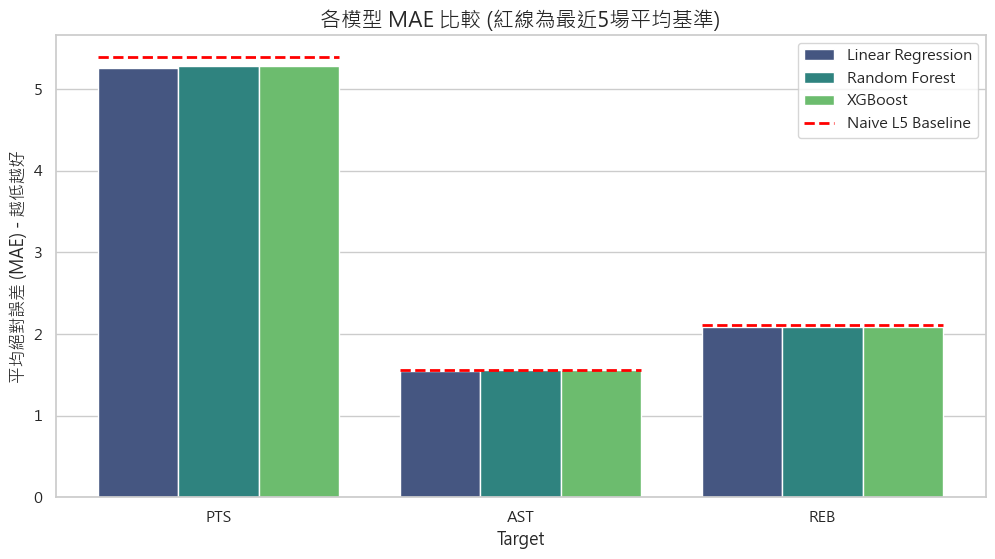

In [6]:
# Cell 6: Visualization
# 轉成 DataFrame
res_df = pd.DataFrame(results)

# 1. 顯示數據表格
print("\n📊 模型效能評估表:")
display(res_df.pivot(index='Model', columns='Target', values=['MAE', 'R2']))

# 2. 畫圖比較 MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=res_df, x="Target", y="MAE", hue="Model", palette="viridis")

# 畫出 Naive Baseline 的線 (紅色虛線)
for i, t in enumerate(targets):
    # 抓出該 Target 的 Naive MAE
    naive_val = res_df[res_df['Target'] == t]['Naive_L5_MAE'].iloc[0]
    # 畫橫線
    plt.hlines(y=naive_val, xmin=i-0.4, xmax=i+0.4, colors='red', linestyles='--', linewidth=2, label='Naive L5 Baseline' if i==0 else "")

plt.title("各模型 MAE 比較 (紅線為最近5場平均基準)", fontsize=15)
plt.ylabel("平均絕對誤差 (MAE) - 越低越好")
plt.legend()
plt.show()